In [1]:
#!/usr/bin/env python
# coding: utf-8

# 因子预处理

In [2]:
import pandas as pd
import numpy as np
import os
os.getcwd()
os.chdir('/Users/Zhang/Documents/华泰Project/数据/数据/股票数据')

def read_data(name):
    file = name + '.h5'
    store = pd.HDFStore(file, mode='r')
    data = store.select('data')
    store.close()
    
    return data
indu = read_data('indu')
indu.head(100)
#indu['industry'].unique()
indu.set_index('code',inplace = True)
indu.head()
# 由于我们就节选了前300个股票在A股池里，我们也要节选前300个在indu里
indu_1 = indu.iloc[:300]
indu_1.shape
indu_name = indu_1['industry'].unique()
stock_name = indu_1.index

##  因子中位数MAD去极值

In [3]:
# In[2]:


# 因子中位数去极值函数
# 使用的方法是MAD（Median Absolute Deviation）
def MAD(df):
    #np.seterr(invalid='ignore')
    df_MAD = df.copy()
    for i in range(df_MAD.shape[0]):
        D_M = df_MAD.iloc[i,:].median()
        new_Array = df_MAD.iloc[i,:].values-D_M
        D_M1 = np.median(np.absolute(new_Array))
        for j in range(df_MAD.shape[1]) :
            if df_MAD.iloc[i,j]>(D_M + 5*D_M1):
                df_MAD.iloc[i,j] = D_M + 5*D_M1
            elif df_MAD.iloc[i,j]<(D_M-5*D_M1):
                df_MAD.iloc[i,j] = D_M - 5*D_M1
            else:
                pass
   
    return df_MAD


# In[3]:

## 缺失值处理函数
得到新的因子暴露度序列后，将因子暴露度缺失的地方设为中信一
级行业相同个股的平均值；

In [4]:
# find stock in same industry，use groupby
def replace_missing(df):
    df_1 = df.copy()
    df_2 = pd.concat([indu_1,df_1.T],axis = 1,sort = True)
    df_3 = df_2.groupby('industry')
    new_df = pd.DataFrame()
    df_4 = pd.DataFrame()
    df_5 = pd.DataFrame()
    count = 0
    
    for i in indu_name:
        if df_2['industry'].isin([i]).any():
            df_4 = df_3.get_group(i)
            count += 1
            if count == 1:
                new_df = series_replace(df_4)
            else:
                df_5 = series_replace(df_4)
        new_df = pd.concat([new_df,df_5],axis = 0)
    new_df.sort_index(inplace = True)    
    return new_df

def series_replace(df_4):
    for i in range(df_4.shape[1]-1):
        if df_4.iloc[:,i+1].isnull().any(): # find nan in pd series
            mean = np.nanmean((df_4.iloc[:,i+1].values))
            df_4.iloc[:,i+1].fillna(mean,inplace = True) # replace nan with mean in pd series   
        else:
            pass
    return df_4


# In[4]:


# 调出市值数据

os.chdir('/Users/Zhang/Documents/华泰Project/Computed_Factor/Fundamental')
import numpy as np
MV_1 = pd.read_csv('MV_1.csv',index_col = 0)
MV_2 = MAD(MV_1)
MV_3 = replace_missing(MV_2)
log_mkt_cap = np.log(MV_3.iloc[:,1:])
#MV_1.head()
log_mkt_cap.head()

,2012-02-29,2012-03-30,2012-04-27,2012-05-31,2012-06-29,2012-07-31,2012-08-31,2012-09-28,2012-10-31,2012-11-30,...,2018-07-31,2018-08-31,2018-09-28,2018-10-31,2018-11-30,2018-12-28,2019-01-31,2019-02-28,2019-03-29,2019-04-30
000001,25.196153,25.111372,25.164065,25.110098,25.075735,25.071769,25.009612,24.931974,24.934256,24.906520,...,25.809289,25.881955,25.968884,25.956133,25.904406,25.805033,25.973399,26.080919,26.117460,26.194739
000002,25.234569,25.234569,25.315725,25.345349,25.307900,25.343185,25.202664,25.252522,25.239388,25.289779,...,26.274025,26.304849,26.315190,26.312306,26.361037,26.295240,26.447950,26.456561,26.549628,26.511408
000004,20.489946,20.341611,20.389639,20.485695,20.382580,20.322988,20.317963,20.340380,20.353836,20.225671,...,21.155134,21.101370,21.012369,20.989467,21.032295,21.020512,20.954100,21.213897,21.321979,21.476064
000005,21.984373,21.984373,22.012472,21.895004,21.735646,21.638008,21.656157,21.681025,21.698417,21.557965,...,21.927556,21.865343,21.858563,21.784455,21.878766,21.765970,21.820430,22.015625,22.107228,21.974076
000006,22.374243,22.418777,22.560667,22.523774,22.454431,22.385564,22.363368,22.363368,22.397685,22.325244,...,22.791516,22.711616,22.763833,22.646708,22.707912,22.668172,22.660420,22.831656,22.932909,22.831656


## 因子行业市值中性化

In [5]:
# 因子与行业市值进行横截面的线性回归，残差就是新的因子（与行业市值正交）

# ### 行业哑变量

# In[5]:


import statsmodels.api as sm
import numpy as np
a = np.zeros(shape=(300,28))
dummy_industry = pd.DataFrame(a,index = stock_name ,columns = indu_name)
dummy_industry
for i in range(dummy_industry.shape[0]):
    for j in indu_name:
        if indu_1.iloc[i,0] == j:
            dummy_industry.iloc[i,dummy_industry.columns.get_loc(j)] = 1
dummy_industry.head()
#dummy_industry.shape


# ### 行业市值中性化函数

# In[6]:


def neutralize(factor_1):
    factor = factor_1.copy()
    residual_Df = pd.DataFrame()
    #const = np.ones((len(log_mkt_cap),1)).reshape(-1,1)
    const = pd.Series(np.ones(300))
    factor.drop(columns = 'industry',inplace = True)
    for i in range(factor.shape[1]):
        xx = pd.concat([log_mkt_cap.iloc[:,i],dummy_industry],axis = 1) # add_constant optimize
        residual_Series = pd.Series()
        y = np.array(factor.iloc[:,i])
        x = sm.add_constant(xx.values)
        model = sm.OLS(y,x)
        residual = model.fit().resid
        if i == 1:
            residual_Series = pd.Series(residual)
            residual_Df = residual_Series
        else:
            residual_Series = pd.Series(residual)
            residual_Df = pd.concat([residual_Df,residual_Series],axis = 1)
    residual_Df.index = factor.index
    residual_Df.columns = factor.iloc[:,:-1].columns
    return residual_Df

## z-score函数

In [6]:
def standardize(df):
    cols = list(df.columns)
    new_df = pd.DataFrame()
    for col in cols:
        new_df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    #new_df = new_df
    #new_df_1 = new_df.insert(0,"industry",indu_1['industry'])
    new_df.index = indu_1.index # stock ID
    return new_df

## 特征处理（使用创建好的MAD，replace_misssing,neutralize,standardize函数）

In [7]:
def preprocess(df):
    df_MAD = MAD(df)
    df_replace = replace_missing(df)
    residual_df = neutralize(df_replace)
    new_df = standardize(residual_df)
    return new_df

# import factors
# EP 
os.chdir('/Users/Zhang/Documents/华泰Project/Computed_Factor/Fundamental')
EP_1 = pd.read_csv('EP_1.csv',index_col = 0)
new_EP = preprocess(EP_1)
new_EP.to_csv(r'/Users/Zhang/Documents/华泰Project/Computed_Factor/Fundamental/new_EP.csv')
# BP
BP_1 = pd.read_csv('BP_1.csv',index_col = 0)
new_BP = preprocess(BP_1)
new_BP.to_csv(r'/Users/Zhang/Documents/华泰Project/Computed_Factor/Fundamental/new_BP.csv')
# EPcut
EPcut_1 = pd.read_csv('EPcut_1.csv',index_col = 0)
new_EPcut = preprocess(EPcut_1)
new_EPcut.to_csv(r'/Users/Zhang/Documents/华泰Project/Computed_Factor/Fundamental/new_EPcut.csv')
# SP
SP_1 = pd.read_csv('SP_1.csv',index_col = 0)
new_SP = preprocess(SP_1)
new_SP.to_csv(r'/Users/Zhang/Documents/华泰Project/Computed_Factor/Fundamental/new_SP.csv')
# NCFP
NCFP_1 = pd.read_csv('NCFP_1.csv',index_col = 0)
new_NCFP = preprocess(NCFP_1)
new_NCFP.to_csv(r'/Users/Zhang/Documents/华泰Project/Computed_Factor/Fundamental/new_NCFP.csv')
# OCFP
OCFP_1 = pd.read_csv('OCFP_1.csv',index_col = 0)
new_OCFP = preprocess(OCFP_1)
new_OCFP.to_csv(r'/Users/Zhang/Documents/华泰Project/Computed_Factor/Fundamental/new_OCFP.csv')
# G_PE
G_PE_1 = pd.read_csv('G_PE_1.csv',index_col = 0)
new_G_PE = preprocess(G_PE_1)
new_G_PE.to_csv(r'/Users/Zhang/Documents/华泰Project/Computed_Factor/Fundamental/new_G_PE.csv')

# 个股收益率数据

In [8]:
import os
os.getcwd()
Stock_Return_1 = pd.read_csv('Stock_Return_1.csv',index_col = 0)
# we need future one month stock return to be the label for month-end factor
Stock_Return = Stock_Return_1.shift(-1)
Stock_Return = Stock_Return.T
Stock_Return.shape

(300, 87)

# 观察因子变化

## 观察因子分布

In [9]:
from ipywidgets import interact
import seaborn as sns
# 2012 2013 2014 2015 2016 2017 2018 2019， new_EP 变化
factor_list = ['new_EP','new_EPcut','new_BP','new_SP','new_NCFP',
              'new_OCFP','new_G_PE']
@interact
def display_dist(factor_name = factor_list):
    ff = eval(factor_name).copy()
    ff.drop(index = '000001',inplace = True)
    return sns.distplot(ff.mean(axis = 1))

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …

## 观察因子在行业变化（月频）

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties # display chinese char
font = FontProperties(fname='/Library/Fonts/Songti.ttc') # display chinese char

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def factor_industry(factor,monthend):
    yy = factor.copy()
    yy.drop(index = '000001',inplace = True)
    factor_indu = yy.groupby(indu_1['industry'])[monthend].apply(lambda x: x.mean()) 
    # if we care about year mean value, we could create year column in factor and [year] and getgroup[2014]
    fig = plt.figure(figsize = (20,8))
    plt.title(str(monthend) + ' ' +  get_df_name(factor),FontProperties=font,fontsize = 25)# 标题
    #plt.ylabel(u"xx",FontProperties=font)  
    plt.xlabel("行业",FontProperties = font,fontsize = 25)
    plt.xticks(FontProperties = font,fontsize = 25)
    ax = factor_indu.plot.bar()

@interact
def disp_end(factor_name = factor_list,
             date = Stock_Return.columns):
    factor_industry(eval(factor_name),date)

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …

## 观察因子在各行业的变化（年频）

In [11]:
# use pandas DatetimeIndex to extract year 
# To visualize annual factor performance
# We fisrt groupby year and get_group('2014')
# Then we groupby industry and sum of each industry to get average of monthly factor 
# then we times sqrt12 to represent annual factor performance
from matplotlib.font_manager import FontProperties # display chinese char
font = FontProperties(fname='/Library/Fonts/Songti.ttc') # display chinese char

def annual(factor,year):
    yy = factor.copy()
    yy.drop(index = '000001',inplace = True)
    yy = yy.T.reset_index()
    yy['year'] = pd.DatetimeIndex(yy['index']).year
    year_group = yy.groupby(['year']).get_group(year)
    zz = pd.DataFrame(year_group)
    ff = zz.T
    hh = ff.groupby(indu_1['industry']).apply(lambda x: x.mean(axis = 1).mean())
    fig = plt.figure(figsize = (20,8))
    plt.title(str(year) + ' ' +  get_df_name(factor),FontProperties=font,fontsize = 25)# 标题
    plt.xticks(FontProperties = font,fontsize = 25) # display chinese character
    plt.xlabel('行业',FontProperties = font,fontsize = 25)
    ax = hh.plot.bar()  

@interact
def display_plt(factor_name = factor_list,
               year = (2012,2019,1)):
    annual(eval(factor_name),year)

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …

# 因子相关系数

In [12]:
# Correlation Heatmap
# 测试因子相关性，如果相关性过高，可能出现共线性，会使模型出现较大误差
# 通过近62个月(2014年2月28日 - 2019年3月29日）月度数据来计算correlation mean
# correlation standard dev
# correlation abs

class corr:
    
    def __init__(self,df1,df2):
        self.df1 = df1
        self.df2 = df2
        self.df  = pd.DataFrame()
        self.mean = []
        self.std = []
    
    def corr_t_ab(self):
        self.df = self.df1.corrwith(self.df2,axis = 0)
        return self.df
    
    def mean_corr(self):
        self.corr_t_ab()
        self.mean = self.df.mean(axis = 0)
        return self.mean
    
    def std_corr(self):
        self.corr_t_ab()
        self.std = self.df.std(axis = 0)
        return self.std

items = [eval(x) for x in factor_list]

matrix_mean = np.eye(len(items))
matrix_std = np.eye(len(items))
# construct mean and std matrix

for j in range(len(items)):
    i = 0
    while i < len(items):
        if i == j:
            i += 1
            continue     
        elif j > i:
            i += 1
            continue
        else: 
            matrix_mean[i][j] = corr(items[i],items[j]).mean_corr()
            matrix_mean[j][i] = matrix_mean[i][j]
            
            matrix_std[i][j] =  corr(items[i],items[j]).std_corr()
            matrix_std[j][i] = matrix_std[i][j]
            i+=1

## 因子系数平均值

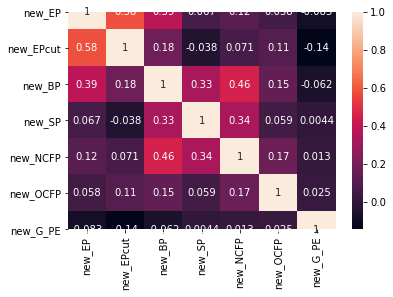

In [13]:
matrix_mean = pd.DataFrame(matrix_mean,index = factor_list,columns = factor_list)
sns.heatmap(matrix_mean,annot = True)

## 因子系数波动（稳定性）

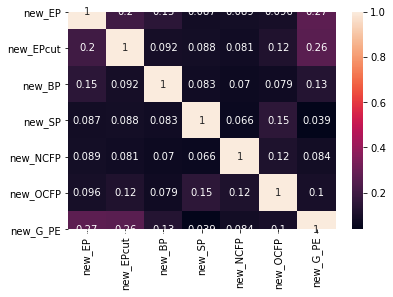

In [14]:
matrix_std = pd.DataFrame(matrix_std,index = factor_list,columns = factor_list)
sns.heatmap(matrix_std,annot = True)

## 因子系数强度

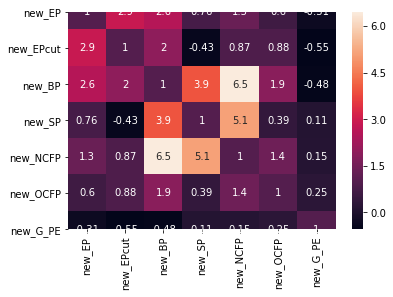

In [15]:
matrix_abs = matrix_mean/matrix_std
matrix_abs = pd.DataFrame(matrix_abs,index = factor_list,columns = factor_list)
lf = sns.heatmap(matrix_abs,annot = True)

#  单因子测试

## 分层投资组合

In [16]:
# 每月月末将股票按因子值排序，分5组，买入第一组的股票，持有到下月最后一个交易日，repeat
# Long-only Portfolio -0.009786 -0.000928
# we will have 5 equal-weighted portfolio
# 我们选择long这一月月末因子排名前60的股票
# 然找出组合里的股票对应的未来一月收益率
# 每个股票是equal-weighted，计算出未来一个月此组合的投资回报

def group_portfolio(factor):
    cols = list(new_EP.iloc[:,:-1].columns) # time-series
    df2 = pd.Series()
    df = []
    for col in cols:
        df2 = Stock_Return[col].groupby(pd.cut(factor[col],5)).mean() # use cut function to split five portfolios
        df.append(df2.iloc[::-1].values) # reverse array
    df = pd.DataFrame(df)
    df.columns = ['a','b','c','d','e']
    df.index = cols            
    return df

import datetime
# converting the index as date
# Extracting year and month
df_1 = pd.DataFrame()
df_1['index'] = pd.to_datetime(new_EP.T.iloc[:-1].index)
df_1['YearMonth'] = pd.DatetimeIndex(df_1['index']).map(lambda x: str(x.year) +'-' + str(x.month))
len(df_1)


# 因子组合收益曲线如果明显分离，就是好的因子，并且收益各组之间是单调关系
import matplotlib.pyplot as plt
from ipywidgets import interact_manual

def factor_portfo(df):
    fig = plt.figure(figsize = (20,8))
    
    plt.plot(df_1['YearMonth'],df['a'],'g')
    plt.plot(df_1['YearMonth'],df['b'],'b')
    plt.plot(df_1['YearMonth'],df['c'],'r')
    plt.plot(df_1['YearMonth'],df['d'],'y')
    plt.plot(df_1['YearMonth'],df['e'],'black')

    
    #plt.title(FontProperties=font,fontsize = 25)# 标题
    graph = plt.xticks(rotation = 90)
    #plt.xticks(FontProperties = font,fontsize = 25) # display chinese character

@interact_manual
def display_factor_port_rank(factor_name = factor_list):
    gp = group_portfolio(eval(factor_name))
    factor_portfo(gp)

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …

## 分层组合表现
使用parent class先构造通过因子值排序的a b c d e股票收益组合，然后使用child class构造组合年化收益率 年化波动率 夏普比率 最大回撤 年化超额收益率 超额收益年化波动率 信息比率 超额收益最大回撤等函数

In [17]:
Index_Return = pd.read_csv('Index_Return_1.csv',index_col = 0)
Index_Return = Index_Return.iloc[:-1] #drop last row

class group_port:
    def __init__(self,factor):
        self.factor = factor
    
    def group_portfolio(self):
        self.cols = list(new_EP.iloc[:,:-1].columns) # time-series
        self.df2 = pd.Series()
        self.df = []
        for col in self.cols:
            self.df2 = Stock_Return[col].groupby(pd.cut(self.factor[col],5)).mean() # use cut function to split five portfolios
            self.df.append(self.df2.iloc[::-1].values) # reverse array
        self.df = pd.DataFrame(self.df)
        self.df.columns = ['a','b','c','d','e']
        self.df.index = self.cols            
        return self.df

class abs_perfor(group_port):
    def __init__(self,factor):
        super().__init__(factor)
        self.df = self.group_portfolio()
        
    def annualized_return(self, N = 12):
        return np.sqrt(N) * (self.df.mean())
    
    def annualized_sharp(self, N = 12):
        return np.sqrt(N) * (self.df.mean()/self.df.std())
    
    def annulized_vol(self, N = 12):
        return np.sqrt(N) * (self.df.std())
    
    def max_DD(self):
        self.list_dd = []
        for i in range(self.df.shape[1]):
            self.ts = (self.df.iloc[:,i] + 1).cumprod()
            self.max_dd = np.ptp(self.ts)/self.ts.max()
            self.list_dd.append(self.max_dd)
        return self.list_dd
    
class alpha_perfor(group_port):
    def __init__(self,factor,benchmark):
        super().__init__(factor)
        self.df = self.group_portfolio()
        self.bench = benchmark
        
    def annualized_alpha_ret(self,N = 12):
        self.al_ret = np.sqrt(N) * ((self.df.subtract(self.bench,fill_value = 0)).mean())
        self.al_ret.drop(['0'],inplace = True)
        return self.al_ret
    
    def annualized_alpha_vol(self,N = 12):
        self.al_vol = np.sqrt(N) * ((self.df.subtract(self.bench,fill_value = 0)).std())
        self.al_vol.drop(['0'],inplace = True)
        return self.al_vol
    
    def annualized_alpha_max_dd(self):
        self.ts_al_ret = self.df.subtract(self.bench,fill_value = 0)
        self.ts_al_ret = self.ts_al_ret.iloc[:,1:]
        self.alpha_dd = []
        
        for i in range(self.ts_al_ret.shape[1]):
            self.ts_alpha = (self.ts_al_ret.iloc[:,i] + 1).cumprod()
            self.max_alpha_dd = np.ptp(self.ts_alpha)/self.ts_alpha.max()
            self.alpha_dd.append(self.max_alpha_dd)
        return self.alpha_dd

def perfor_df(factor):
    
    factor_obj = abs_perfor(factor)
    annual_ret = factor_obj.annualized_return()
    annual_sharp = factor_obj.annualized_sharp()
    annual_vol = factor_obj.annulized_vol()
    annual_max_DD = factor_obj.max_DD()
    
    alpha_obj = alpha_perfor(factor,Index_Return)
    alpha_ret = alpha_obj.annualized_alpha_ret()
    alpha_vol = alpha_obj.annualized_alpha_vol()
    alpha_max_dd = alpha_obj.annualized_alpha_max_dd()
    
    dict1 = {'annual_ret':annual_ret,'annual_sharp':annual_sharp,
            'annual_vol':annual_vol,'annual_max_DD':annual_max_DD,
            'alpha_ret':alpha_ret,'alpha_vol ':alpha_vol,
            'alpha_max_dd':alpha_max_dd}
    
    performance_df = pd.DataFrame(dict1,index = ['a','b','c','d','e'])
    
    return performance_df

@interact_manual
def display_perfor_table(factor_name = factor_list):
    return perfor_df(eval(factor_name))

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …

## 因子值与股票收益率关系

### IC

In [18]:
# 计算IC 
# IC均值大于0.03就是有效因子
import scipy
def IC(factor):
    cols = factor.columns
    list2 = []
    for col in cols:
        x = np.empty([1,1]) # PAY ATTENTION to CREATE EMPTY ARRAY
        x = scipy.stats.pearsonr(factor[col],Stock_Return[col])
        list2.append(x[0])
        #df = pd.Da(list1,index = cols)
    return list2

def IC_plot(factor):
    df_2 = pd.DataFrame()
    df_2['index'] = pd.to_datetime(new_EP.T.index)
    df_2['YearMonth'] = pd.DatetimeIndex(df_2['index']).map(lambda x: str(x.year) +'-' + str(x.month))

    dts = new_EP.T.index#.to_pydatetime()
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(111)
    ax.plot(df_2['YearMonth'],factor,'b')
    graph = plt.xticks(rotation = 45)
    
@interact
def display_IC(factor_name = factor_list):
    f = IC(eval(factor_name))
    IC_plot(f)

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …

### RankIC

In [19]:
# using spearman because relationship between two RVs might not be linear.
# spearman illustrates montonic relation between the two

# rankIC是当前个股因子值与个股下一期收益率的相关系数
# 秩相关系数大于多少是有效的
def rankIC(factor):
    cols = factor.columns
    list1 = []
    for col in cols:
        x = np.empty([1,1]) # PAY ATTENTION to CREATE EMPTY ARRAY
        x = scipy.stats.spearmanr(factor[col],Stock_Return[col])
        list1.append(x[0])
    return list1

def rank_IC_plot(factor):
    df_2 = pd.DataFrame()
    df_2['index'] = pd.to_datetime(new_EP.T.index)
    df_2['YearMonth'] = pd.DatetimeIndex(df_2['index']).map(lambda x: str(x.year) +'-' + str(x.month))

    dts = new_EP.T.index#.to_pydatetime()
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(111)
    ax.plot(df_2['YearMonth'],factor,'b')
    graph = plt.xticks(rotation = 45)
    
@interact
def display_rank_IC(factor_name = factor_list):
    f = rankIC(eval(factor_name))
    rank_IC_plot(f)

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …

### RankIC分布

In [20]:
@interact
def disp_distribu_RankIC(factor_name = factor_list):
    f = rankIC(eval(factor_name))
    sns.distplot(f)

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …

### IR

In [21]:
def IR(factor):
    IC_factor = IC(factor)
    IR_factor = IC_factor/(np.std(IC_factor))
    return IR_factor

def IR_plot(factor):
    df_2 = pd.DataFrame()
    df_2['index'] = pd.to_datetime(new_EP.T.index)
    df_2['YearMonth'] = pd.DatetimeIndex(df_2['index']).map(lambda x: str(x.year) +'-' + str(x.month))

    dts = new_EP.T.index#.to_pydatetime()
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(111)
    ax.plot(df_2['YearMonth'],factor,'b')
    graph = plt.xticks(rotation = 45)
    
@interact
def displayIR(factor_name = factor_list):
    ff = IR(eval(factor_name))
    return IR_plot(ff)

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …

## 回归测试

In [22]:
import pandas as pd 
import numpy as np

# calculate factor returns using linear regression 
# then use t-test to validate
xx = pd.concat([new_EP.iloc[:,1],dummy_industry],axis = 1) # add_constant optimize
#factor_Series = pd.Series()
y = np.array(Stock_Return.iloc[:,1])
x = sm.add_constant(xx.values,prepend = False) # add constant in last column

model = sm.OLS(y,x)
results = model.fit()
tvalue = results.params[0]

def regress_test(factor_1):
    list1 = []
    factor = factor_1.copy()
    const = pd.Series(np.ones(300))
 
    for i in range(factor.shape[1]):
        xx = pd.concat([factor.iloc[:,i],dummy_industry],axis = 1) # add_constant optimize
        y = np.array(Stock_Return.iloc[:,i])
        x = sm.add_constant(xx.values,prepend = False) # add constant in last column
        model = sm.OLS(y,x)
        results = model.fit()
        factor_ret = results.params[0]
        list1.append(factor_ret)
        
    return list1

# 计算绝对值t>2在t值序列的占比
def t_percent(factor_1):
    list1 = regress_test(factor_1)
    t_series = list1/np.std(list1)
    num_t = len(t_series[np.abs(t_series) > 2])
    num_tseries = len(t_series)
    t_pt  = num_t/num_tseries
    print("{:.2%}".format(t_pt))

### 绝对值t>2的占比

In [23]:
@interact
def display_t_percentage(factor_name = factor_list):
    t_percent(eval(factor_name))

interactive(children=(Dropdown(description='factor_name', options=('new_EP', 'new_EPcut', 'new_BP', 'new_SP', …